# Part 1 - Algebraic Dynamics Example [Given code]

This is a modifed version of the Algebraic Dynamics example found here:   
https://algebraicjulia.github.io/AlgebraicDynamics.jl/dev/examples/Lotka-Volterra/

The modifications are extra comments to make each part of the code more explicit, and a different method is used to solve the final ODE system. 

In [1]:
# Libraries
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Plots
using Plots.PlotMeasures
using DifferentialEquations

In [2]:
# Input parameters
α = 0.3; 
β = 0.015;
γ = 0.015;
δ = 0.7;

The example considers a predator-prey model. For Each species has an associated differential equation that determines the population (state). These can declared explicitly as annoymous Julia functions. The Number of inputs is fixed and dictated by Algebraic Dynamics.    

See this link for details on the required inputs:   
https://algebraicjulia.github.io/AlgebraicDynamics.jl/dev/api/#AlgebraicDynamics.DWDDynam.ContinuousMachine

In [3]:
# Input differential equations
dotr(u, x, p, t) = [α*u[1] - β*u[1]*x[1]]       # Rabbits
dotf(u, x, p, t) = [γ*u[1]*x[1] - δ*u[1]]       # Foxes

# u = State,
# x = Control inputs, functions with respect to time
# p = Parameters, constants that dictate behavior 
# t = time variable, can be used an input for X

dotf (generic function with 1 method)

These functions (which represent the differential equations) must be passed onto a Machine type. These have a fixed number of inputs that depend on the properties of the ODEs. 

See this link for the parameter list of a Machine:  
https://www.algebraicjulia.org/blog/post/2021/01/machines/   

Algebraic Julia has some default Machine types. These include is a continuous and discrete case. More information is found here:    
https://algebraicjulia.github.io/AlgebraicDynamics.jl/dev/api/#Resource-Sharers-and-Machines  

Note: a machine type is required for each ODE function.

In [4]:
# Machine states:
rabbit = ContinuousMachine{Float64}(1,          # Number of inputs
									1,          # Number of states
									1,          # Number of outputs
									dotr,       # Input function
									u -> u)     # Readout function 		[State is output]

fox    = ContinuousMachine{Float64}(1,1,1, dotf, u -> u)

ContinuousMachine(ℝ^1 × ℝ^1 → ℝ^1)

Next an arbitrary wiring diagram can be defined. It needs to be able to incorportate each ODE function into the diagram. Each "Box" can be thought of as an ODE, while the way the ports connect represent how two ODES can interconnect.

In [5]:
# Define Wiring diagram
rabbitfox_pattern = WiringDiagram([], [])               # Diagram with two boxes

rabbit_box = add_box!( rabbitfox_pattern,               # Insert box into diagram 
                        Box(:rabbit, [:pop], [:pop]) )  # Box names Rabbit, has 2 objects "pop" as ports
        
fox_box    = add_box!( rabbitfox_pattern, Box(:fox, [:pop], [:pop]) )

	# Connect boxes of diagram 
add_wires!(rabbitfox_pattern, Pair[
    (rabbit_box, 1) => (fox_box, 1),      # Port output goes to port input
    (fox_box, 1) => (rabbit_box, 1)       # Output goes to input
])

This wiring diagram is closed, meaning it receives no external inputs from anything and depends only on its initial conditions. This can be modified and is discussed in greater detail here:    

https://www.algebraicjulia.org/blog/post/2021/01/resource_sharers/

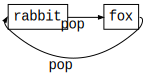

In [6]:
# Function to display diagram
show_diagram(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Courier",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Courier",
  )
)

# Display diagram:
show_diagram(rabbitfox_pattern)

This step is important and bridges the gap between a schematic and a set of equations. By using the oapply function, one can "fill" the boxes with the ODE information found in the "Machine" types defined earlier. As these are constructed directly from the executable functions, the information is passed onto the combined system.

See this link for more information:  
https://algebraicjulia.github.io/AlgebraicDynamics.jl/dev/api/#oapply

In [7]:
#--- Part 3: Compose sections of wiring diagram
rabbitfox_system = oapply(rabbitfox_pattern,     # Wiring diagram  
                          [rabbit, fox])         # Machine types used by diagram [Must match number of boxes]

ContinuousMachine(ℝ^2 × ℝ^0 → ℝ^2)

The result of the oapply function is another Machine type. This needs to be converted into another datatype that can be fed into a differential equation solver. This is the final step related to the Algebraic dynamics library. 

In [9]:
# Input parameters
u0 	  = [10.0, 100.0]
tspan = (0.0, 100.0)

# Transform machine type into solvable system
prob = ODEProblem(rabbitfox_system,     # Machine to transform            
                  u0,                   # Initial conditions
                  tspan)                # Solution interval

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: false
timespan: (0.0, 100.0)
u0: [10.0, 100.0]

With the above format, the system is fed into an ODE solver of choice. The result is a set of arrays with the solution of the combined ODE system. Here one can see the connection between the wiring diagram and a numerical output.

In [10]:
# Solve system
solution = solve( prob, alg_hints=[:stiff] );      # Note: ODE system is stiff and soft methods become unstable

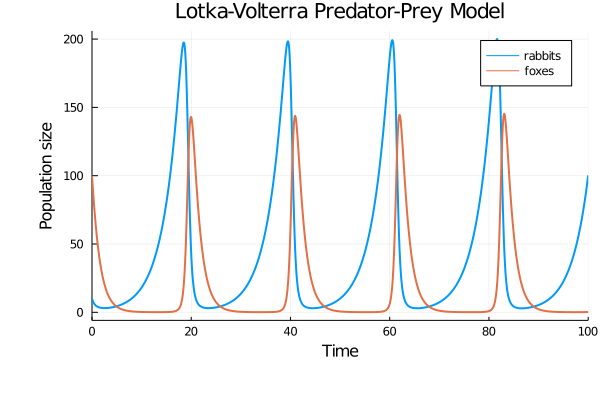

In [11]:
# Display results
plot(solution, 
    lw=2, 
    bottom_margin=10mm, 
    left_margin=10mm, 
    title = "Lotka-Volterra Predator-Prey Model", 
    label=["rabbits" "foxes"] )                  

xlabel!("Time")
ylabel!("Population size")

#  Part 2 - Simple 1rst order system

This sketch illustrates the simplest kind of feedback: a scalar value that is determined by the value of its derivative. 

In [12]:
# Input parameter
alpha = 1.5;         # Decay rate, alpha > 4 is unstable for most non-stiff methods

The Algebraic Dynamic functions have two important input vectors, the state U and the external inpts X. Within a wiring diagram each box has a particular state U. The boxes can interact with each other via their outputs and inputs. A box outputs its own state, and can received as input an external value. This external value can also be the state of another box, or even its own output.   
   
However, the state of one box cannot be directly fed into another. It must first be transformed into an output, which in turn can become the input to another box. 

In [13]:
# Define input function:
inputFunc(t) = t < 1 ? alpha : 0;

# Define derivative of state

#Note: 
# The state of the system is implict here. It is not used directly.
# Rather it is obtained by the feedback loop between the input and output values.

# X = input vector
                                  # One can add time dependent inputs to the equation
rate(u, x, p, t) = [ -alpha*x[1] + inputFunc.(t) ] # Note indeces begin from 0.       

rate (generic function with 1 method)

The equation must be transformed into a state machine as before.

In [14]:
first_machine = ContinuousMachine{Float32}( 1,			# Input is state
                                            1,			# 1 state variable
                                            1, 			# Output is state
                                            rate, 		# Input function
                                            u -> u)		# State is transformed into the state

ContinuousMachine(ℝ^1 × ℝ^1 → ℝ^1)

The system consists of a single box with a connection to itself. This means it has 2 ports that connect with themselves.

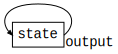

In [15]:
# Define Wiring diagram
first_diagram = WiringDiagram([],[])               # System has only 1 function
  
first_box = add_box!( first_diagram, Box(:state, [:input], [:output]) );  # Single box with 2 ports

# Connect state to itself
add_wires!(first_diagram, [
  (first_box,1) => (first_box,1)      # First output connects to first input
])

show_diagram( first_diagram )

As the system one system only outputs a scalar value, and receives a scalar value, it operates solely in one dimension.

In [16]:
first_system = oapply(first_diagram, [first_machine] )

ContinuousMachine(ℝ^1 × ℝ^0 → ℝ^1)

In [17]:
# Initial conditions
u_init = [0];         # Value of the state
t_span = (0, 5);      # Interval of solution

# Solve ODE:          Note: Test equation y = -K.y' is stiff
sol = solve( ODEProblem(first_system, u_init, t_span), alg_hints=[:stiff] ); 

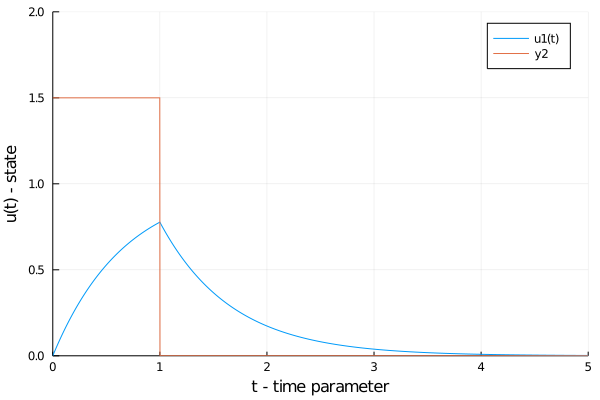

In [18]:
# Display the result: [ideal solution is an exponential decay]
plot( sol )
plot!( inputFunc )

xlabel!("t - time parameter")   # Note: Don't add ; to allow plot to be shown.
ylabel!("u(t) - state")
ylims!(0,2)

# Part 3 - Simple 2nd order system

The idea here is to replicate the behavior of a spring-mass system using wiring diagrams. Unlike the previous case, a second order system has two state variables. This sketch illustrates how this extra state can be dealt with.

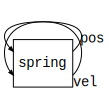

In [19]:
# Define wiring diagram:
second_diagram = WiringDiagram( [],[] )

# Each box has 2 inputs and 2 ouputs [All state variables]
box_spring = add_box!(second_diagram, Box(:spring, [:pos, :vel], [:pos, :vel]) )

# All state outputs interconnect
add_wires!( second_diagram, [
            (box_spring,1) => (box_spring,1) ,    # Position
            (box_spring,2) => (box_spring,2) ])   # Velocity

show_diagram(second_diagram)

As there are two state values, the equation of the system must returns a vector and not a scalar. 

In [20]:
# Input parameters:
k_spring = 2;
c_damp = 0.5;

# Define Functions:

# Input vector: [x]
# x[1] = x
# x[2] = x'
# x[3] = x''

eq_spring(u, x, p, t) = [x[2], -k_spring*x[1] - c_damp*x[2] ]

eq_spring (generic function with 1 method)

Since the number of state variables increased, the state machine must be of higher dimension. It has two values so the output/input vector must exist in two dimensions.

In [21]:
#Define machines
spring_machine = ContinuousMachine{Float32}( 2,			# Input are pos, vel
                                             2,			# 2 states, position and velocity
                                             2, 		# Outputs are pos, vel
                                             eq_spring, # Input function
                                             u -> u)	# State is transformed into the state

# Define composed system
second_machine = oapply(second_diagram, [spring_machine] )

ContinuousMachine(ℝ^2 × ℝ^0 → ℝ^2)

Each additional state requires an additional initial condition. Nonetheless, this is easily accomodated by expanding the vector of initial values. This must have the same dimensions as the state machine's output.

In [22]:
# Initial condition
u_init = [1, 0];       # Position, velocity

# Interval of solution
t_span = (0, 20);      

# Solve ODE:          Note: y'' = -K.y - c*y' is stiff
sol = solve( ODEProblem(second_machine, u_init, t_span), alg_hints=[:stiff] );

The ideal behavior of a 2nd order system is that of an exponentially decaying sine wave. 

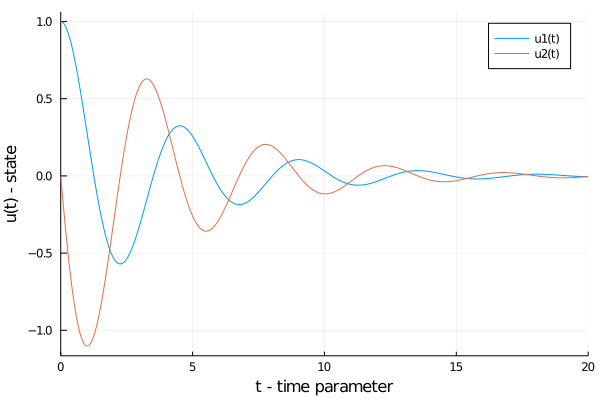

In [23]:
# Display results
plot(sol)
xlabel!("t - time parameter")   
ylabel!("u(t) - state")

# Part 4 - 2nd order closed system - multiple boxes

Consider a set of second order systems. A simple one is two masses connected together with a spring and a dashpot. To constrain the system one of the masses can be connected to a fixed wall.

![Cat](https://raw.githubusercontent.com/rgCategory/composition_notebook/main/images/spring_mass.png)

The set of ODE's that define this system include two states: the position and velocity of each box. However, the masses are not independent of each other. The spring/dashpot of the 2nd mass acts as the bridge between both systems. This generates a system of equations of ODE's.

#### - Iteration 1 

<b>Note: </b> The state of each box is defined explicitly here. That is, the variable u is modified directly rather than modified indirectly as in the examples of part 2 and part 3.

In [24]:
# Spring and damping constant of each mass.
k_spring1 = 1;      # Mass #1:
c_damp1 = 1.0;

k_spring2 = 5;     # Mass #2:
c_damp2 = 10.0;
     
# Reaction of outer spring
accel_2(u, x) = k_spring2*(x[1] - u[1]) + c_damp2*(x[2] - u[2]);     
                        
# Equations of each mass: 
eq_mass1(u, x, p, t) = [ u[2], -k_spring1*u[1] - c_damp1*u[2] + accel_2(u,x)];                
eq_mass2(u, x, p, t) = [ u[2], accel_2(u,x) ];

Each mass can be thought of as a box within a wiring diagram. As the state of mass1 determines the state of mass2 (and vice versa) there is a feedback loop between the boxes. However, an important question arises afterwords: 

How many outputs and inputs do the boxes have? 

This is an extremely important question as it determines how the rest of the code is constructed. In an abstract sense, one can say each box receives a single input (a state) and transmits a single output (the dependent state). Lets see if this abstration works: 

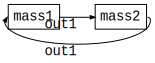

In [35]:
# Assume the diagram is closed and contains no inputs or outputs.
spring_damper = WiringDiagram( [], [] ) 

# Each box has a single input and output
box_mass1 = add_box!(spring_damper, Box(:mass1, [:in1], [:out1]) )
box_mass2 = add_box!(spring_damper, Box(:mass2, [:in1], [:out1]) )

# Interconect system
add_wires!( spring_damper, [
            (box_mass1, 1) => (box_mass2, 1),
            (box_mass2, 1) => (box_mass1, 1)
        ])   

# Display diagram
show_diagram(spring_damper)

Each mass requires a state machine. To assign a machine one must explicitly define the number of inputs, outputs, and states. The number of states is not ambiguous. Each spring has a position and velocity hence two state variables. However, the number of inputs and outputs is ambiguous:

Is the number of outputs and inputs determined by the wiring diagram?   
How many values are encoded in each wire?


In [36]:
# Assume the wiring diagrams determine the number of inputs and outputs:
# This means a single input and a single output

mass1_machine = ContinuousMachine{Float32}( 1,			# Inputs
                                            2,			# States
                                            1, 		    # Outputs
                                            eq_mass1,   # Input function
                                            u -> u);    # State is transformed into the state

mass2_machine = ContinuousMachine{Float32}( 1, 2, 1, eq_mass2, u -> u);

spring_damper_machine = oapply(spring_damper, [mass1_machine, mass2_machine] )

ContinuousMachine(ℝ^4 × ℝ^0 → ℝ^4)

This seems to compile succesfully. The next question is whether the ODE solver will compile.

In [40]:
# Initial conditions
u_init = [1, 0, 1, 0];       # There are 4 initial states: p1, v1, and p2, v2

# Interval of solution
t_span = (0, 20);      

# Solve ODE:          Note: y'' = -K.y - c*y' is stiff

try
    sol = solve( ODEProblem(spring_damper_machine, u_init, t_span), alg_hints=[:stiff] );
catch error
    print(error)
end

BoundsError(1:1, (1:2,))

Evidently it does not. Decreasing the number of initial values is unreasonable as these are theoretically required. There are 4 state values and each of these need an initial condition to reach a particular solution.   

#### - Iteration 2

The error mentions the inability to access elements of a single element array. We assumed each box had just 1 input and 1 output. Perhaps increasing these values will permit succesful compilation. A reasonable number of inputs and outputs is 2. Each mass has two state values and these are used by the following mass to determine its own state. 

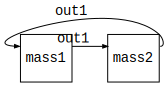

In [28]:
# Assume the diagram is closed and contains no inputs or outputs.
spring_damper = WiringDiagram( [], [] ) 

# Each box has two inputs and two outputs
box_mass1 = add_box!(spring_damper, Box(:mass1, [:in1, :in2], [:out1, :out2]) )
box_mass2 = add_box!(spring_damper, Box(:mass2, [:in1, :in2], [:out1, :out2]) )

# Connect the system - Only 1 wire per box
add_wires!( spring_damper, [
            (box_mass1, 1) => (box_mass2, 1),
            (box_mass2, 1) => (box_mass1, 1)
        ])   

# Display diagram
show_diagram(spring_damper)

The boxes have expanded to accomodate for the extra inputs and outputs. Since number of ports changes, the state machines much change as well. 

In [29]:
# The box have two state values, and these are equal to the number of inputs and outputs.

mass1_machine = ContinuousMachine{Float32}( 2,			# Inputs: pos and vel
                                            2,			# States
                                            2, 		    # Outputs: pos and vel
                                            eq_mass1,   # Input function
                                            u -> u);    # State is transformed into the state

mass2_machine = ContinuousMachine{Float32}( 2, 2, 2, eq_mass2, u -> u);

spring_damper_machine = oapply(spring_damper, [mass1_machine, mass2_machine] )

ContinuousMachine(ℝ^4 × ℝ^0 → ℝ^4)

Using this scheme the ODE solver compiles succesfully. However, it is still a question whether the output of the composed system is reasonable. The system appears to be extremely damped in spite of the first dashpot being comparatively weak.

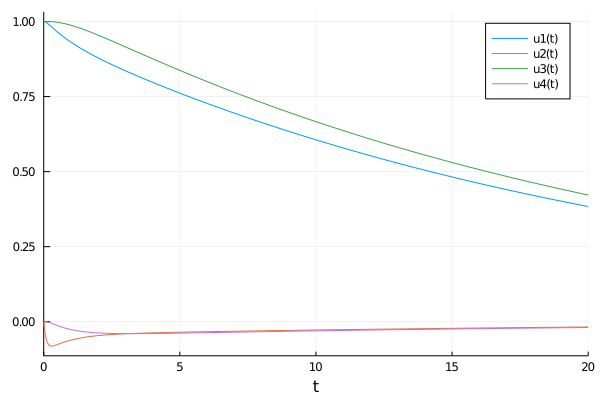

In [30]:
# Solve ODE:          Note: y'' = -K.y - c*y' is stiff
sol = solve( ODEProblem(spring_damper_machine, u_init, t_span), alg_hints=[:stiff] );

plot(sol)

#### - Iteration 3

Perhaps adding another connection to the wiring diagram will change the behaviour. This is easily accomplished.

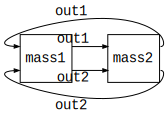

In [31]:
# Assume the diagram is closed and contains no inputs or outputs.
spring_damper = WiringDiagram( [], [] ) 

# Each box has two inputs and two outputs
box_mass1 = add_box!(spring_damper, Box(:mass1, [:in1, :in2], [:out1, :out2]) )
box_mass2 = add_box!(spring_damper, Box(:mass2, [:in1, :in2], [:out1, :out2]) )

# Connect the system - 2 wires per box
add_wires!( spring_damper, [
            (box_mass1, 1) => (box_mass2, 1),
            (box_mass2, 1) => (box_mass1, 1),
            (box_mass1, 2) => (box_mass2, 2),
            (box_mass2, 2) => (box_mass1, 2)
        ])   

# Display diagram
show_diagram(spring_damper)

As the wiring diagram changed, the state machines need to be recompiled. Like before, number of stated outputs/inputs permit compilation.

In [32]:
mass1_machine = ContinuousMachine{Float32}( 2,			# Inputs: pos and vel
                                            2,			# States
                                            2, 		    # Outputs: pos and vel
                                            eq_mass1,   # Input function
                                            u -> u);    # State is transformed into the state

mass2_machine = ContinuousMachine{Float32}( 2, 2, 2, eq_mass2, u -> u);

spring_damper_machine = oapply(spring_damper, [mass1_machine, mass2_machine] )

ContinuousMachine(ℝ^4 × ℝ^0 → ℝ^4)

This system can also be solved without issue. However, the output of the composed ODE's is completely different. The results appears to be far more reasonable. Indifferent how strong the 2nd damper is, the overall damping of the system of determined by the first damper. In a limiting case an infitely stiff 2nd spring causes the first and second states to be equal. 

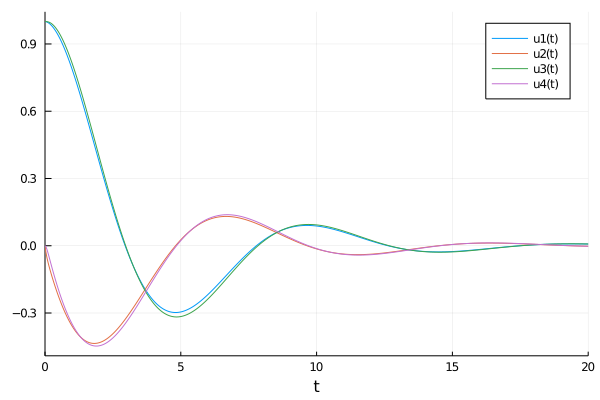

In [33]:
# Solve ODE:          Note: y'' = -K.y - c*y' is stiff
sol = solve( ODEProblem(spring_damper_machine, u_init, t_span), alg_hints=[:stiff] );

plot(sol)

This experiment leads to an unfortunately conclusion. It seems each variable in a state needs to be <i>explicitly</i> assigned a wire for the system to behave as expected. Each wire only encodes a single scalar value rather than an array of values.   

It seems unlikely there isn't a way to trasmit an array with a single wire. One answer might lie in using a different state machine. The following link seems to indicate this:   

https://www.algebraicjulia.org/blog/post/2021/01/resource_sharers/   

The idea is to use a resource sharer rather than a continuous machine to compose the system. These types do not require multiple wires to encode multiple states. However, composing with a resource sharer seem to differ from a continuous machine. One seems to form a set of conneced ODE's while the other adds the equations together.

# Part 5 - Open systems - Inputs

Consider a diagram that has wires entering and exiting the system. This is an open system as the state will depend on external inputs rather than being self contained. This next example shows a in which one can achieve this.   

See this link for more information on inputs:  
https://algebraicjulia.github.io/AlgebraicDynamics.jl/dev/api/#SciMLBase.ODEProblem

#### -Iteration 1:

Consider a simple box containing a first order system. It receives a scalar value and returns the modified state.

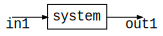

In [30]:
# Entire system as a single input and output
input_system = WiringDiagram( [:in1], [:out1] );

# The box also has 1 input and output
box_1 = add_box!(input_system, Box(:system, [:in1], [:out1]) );

# Connect system
add_wires!( input_system, [
            # Inputs
            (input_id(input_system),1) => (box_1, 1),  
            # Outputs
            (box_1,1) => (output_id(input_system), 1)
        ]);

# Display
show_diagram(input_system)

As the system is first order it only has a single state. This is shown the associated equation and the state machine.

In [34]:
# Decay constant
c_box1 = 1.0;

# Scalar output
eq_box1(u, x, p, t) = [ -( u[1] - x[1] )*c_box1 ];

# State machine
box1_machine = ContinuousMachine{Float32}( 1,		# Input 
                                           1,		# states
                                           1, 		# Outputs
                                           eq_box1, # Input function
                                           u -> u);	# State is transformed into the state

input_machine = oapply(input_system, [box1_machine] )

ContinuousMachine(ℝ^1 × ℝ^1 → ℝ^1)

As the system has an input the value of this input must be specified to solve the system. Assume the input is a constant value. Let's see how the system behaves:

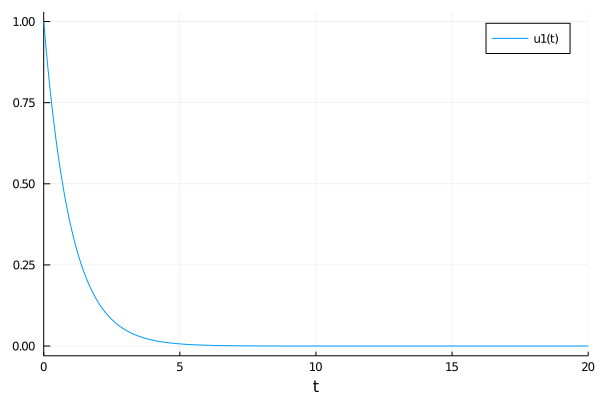

In [36]:
# Initial condition
u_init = [0];

# Input value
xs_init = [1];
      
# Solve ODE:          Note: y'' = -K.y - c*y' is stiff
sol = solve( ODEProblem(input_machine, xs_init, u_init, t_span), alg_hints=[:stiff] );

# Display
plot(sol)

Based on this behavior, it seems the input determines the initial value of the state. Lets inspect what directly changing the state accomplishes: 

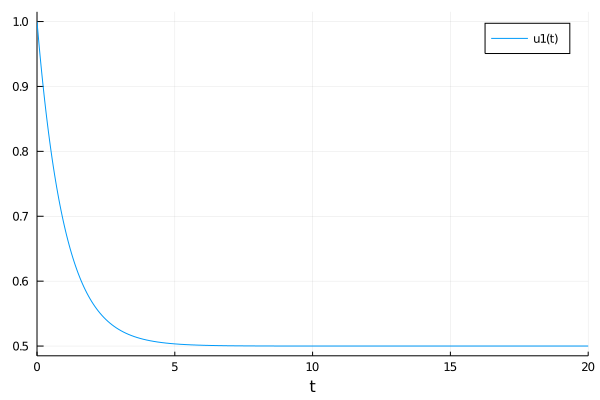

In [38]:
# Initial condition
u_init = [0.5];
     
# Solve ODE:          Note: y'' = -K.y - c*y' is stiff
sol = solve( ODEProblem(input_machine, xs_init, u_init, t_span), alg_hints=[:stiff] );

# Display
plot(sol)

It seems the initial value of the state <i>u0</i> determines the target state of the system, while the input <i>xs</i> determines the initial boundary value. 

#### - Iteration 2:  

Consider a more complicated system with an additional box. Assume that each box only has a single first order state and that they're connected in series. However, an important question arises from this configuration:  

How many inputs should be declared for the system to compile?  

One would expect this to be a single value. After all that is the only value entering the system. Let's see if this is what actually works.

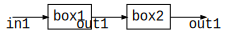

In [12]:
# System has a single input and output
input_system = WiringDiagram( [:in1], [:out1] );

# Each box only has 1 input and 1 output
box_1 = add_box!(input_system, Box(:box1, [:in1], [:out1]) );
box_2 = add_box!(input_system, Box(:box2, [:in1], [:out1]) );

# Connection of the system
add_wires!( input_system, [
            # Inputs
            (input_id(input_system),1) => (box_1, 1), 
            # Connections
            (box_1,1) => (box_2, 1),
            # Outputs
            (box_2,1) => (output_id(input_system), 1)
        ]);

# Display
show_diagram(input_system)

As each box contains a 1rst order system, one can expect the entire system to have two state variables and hence two initial values.

In [13]:
# Decay constant
c_box1 = 1.0;
c_box2 = 1.0;

# Scalar output
eq_box1(u, x, p, t) = [ -( u[1] - x[1] )*c_box1 ];
eq_box2(u, x, p, t) = [ -( u[1] - x[1] )*c_box2 ];

# State machines
box1_machine = ContinuousMachine{Float32}( 1,		# Input 
                                           1,		# states
                                           1, 		# Outputs
                                           eq_box1, # Input function
                                           u -> u);	# State is transformed into the state

box2_machine = ContinuousMachine{Float32}( 1,		# Input 
                                           1,		# states
                                           1, 		# Outputs
                                           eq_box2, # Input function
                                           u -> u);	# State is transformed into the state

input_machine = oapply(input_system, [box1_machine, box2_machine] )

ContinuousMachine(ℝ^2 × ℝ^1 → ℝ^2)

Unfortuately, these assumptions are incorrect. In order for the code the compile, only a single state variable needs to be initialized while <i>two</i> inputs need to be defined. This the opposite of what was expected. 

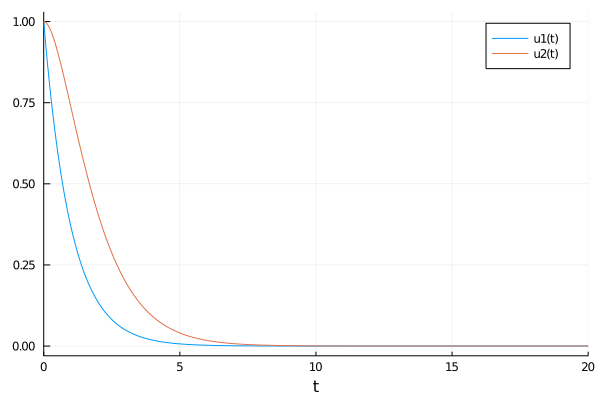

In [23]:
# Initial condition
u_init = [0];       # Only a sigle state can be initialized.

# Interval of solution
t_span = (0, 20);

# Initial state
u_init = [0];     # Defines target value of system

# Input value
xs_init = [1, 1];   # Two input must be defined for the system to work.
                    # These dictate the initial value of the state.
      
# Solve ODE:          Note: y'' = -K.y - c*y' is stiff
sol = solve( ODEProblem(input_machine, xs_init, u_init, t_span), alg_hints=[:stiff] );

# Display
plot(sol)

There is a contradiction here. If only a single state was initialized, how can the solution contain two outputs? Perhaps the composition made by Algebraic Dynamics fixes both states together.

#### -Iteration 3:

Consider an alternative system. Take the above system and add an additional input to the diagram. This makes the 2nd required input explicit. 

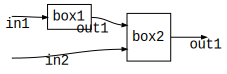

In [19]:
# The net system has two inputs now, and a single output
input_system = WiringDiagram( [:in1, :in2], [:out1] );

# The additional box has two inputs. One from the previous box, and an exterior input.
box_1 = add_box!(input_system, Box(:box1, [:in1]      , [:out1]) );
box_2 = add_box!(input_system, Box(:box2, [:in1, :in2], [:out1]) );

add_wires!( input_system, [
            # Inputs
            (input_id(input_system),1) => (box_1,1), 
            (input_id(input_system),2) => (box_2,2),
            # Connections    
            (box_1, 1) => (box_2 ,1),
            # Outputs
            (box_2,1) => (output_id(input_system), 1)
        ]);   

# System diagram
show_diagram(input_system)

Like before, the boxes only contain first order systems. We also know that the number of wires determines the number of outputs of each box. This also applies to the inputs. Beyond that, the diagrams from iteration 2 and iteration 3 are identical. 

In [24]:
# Define a state machine for each box. 
box1_machine = ContinuousMachine{Float32}( 1,		# Inputs
                                           1,		# States
                                           1, 		# Outputs 
                                           eq_box1, # Input function
                                           u -> u);	# State is transformed into the state

box2_machine = ContinuousMachine{Float32}( 2,		# Inputs (two unlike 1 before)
                                           1,		# States
                                           1, 		# Outputs
                                           eq_box2, # Input function
                                           u -> u);	# State is transformed into the state

# Compose systems
input_machine = oapply(input_system, [box1_machine, box2_machine] )

ContinuousMachine(ℝ^2 × ℝ^2 → ℝ^2)

The system return the same output as before. However, a extra initial state value is required for the code to compile. Beyond that the output behaves the same. Strangely, the value of the second stage does not affect the output.

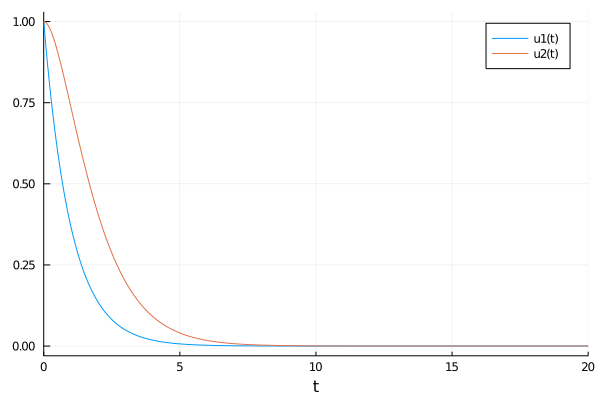

In [27]:
# Initial condition
u_init = [0, -10];      # The fist state affects the target value
                        # The second state has no effect on the output yet must be defined
# Position, velocity
xs_init = [1, 1];       # Initial values of states [inputs]

# Interval of solution
t_span = (0, 20);      

# Solve ODE:          Note: y'' = -K.y - c*y' is stiff
sol = solve( ODEProblem(input_machine, xs_init, u_init, t_span), alg_hints=[:stiff] );

plot(sol)

#### - Iteration 4: 2nd order system

We know from Part 4 that the number of outputs/inputs must match the number of wires attached to a box. Given an increase in connections, how do the inputs to the system chage with the added states?  

The next example considers a two boxes with 2nd order systems. Assume each has two inputs and two ouputs. 

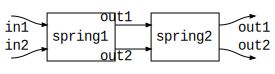

In [24]:
# Net diagram has two inputs and two outputs
spring_damper = WiringDiagram( [:in1, :in2], [:out1, :out2] )

# Each box has 4 ports due to the number of states
box_spring1 = add_box!(spring_damper, Box(:spring1, [:in1, :in2], [:out1, :out2]) )
box_spring2 = add_box!(spring_damper, Box(:spring2, [:in1, :in2], [:out1, :out2]) )

# Connections
add_wires!( spring_damper, [
            # Inputs
            (input_id(spring_damper), 1) => (box_spring1, 1), 
            (input_id(spring_damper), 2) => (box_spring1, 2),
            # Connections
            (box_spring1, 1) => (box_spring2, 1),
            (box_spring1, 2) => (box_spring2, 2),
            # Outputs
            (box_spring2, 1) => (output_id(spring_damper), 1),
            (box_spring2, 2) => (output_id(spring_damper), 2)
        ])   

show_diagram(spring_damper)

For simplicity, assume the state of the first mass doesn't get modified by the second mass. That is, the motion of mass 1 acts as a forcing function for mass 1.

In [25]:
# Spring parameters
k_spring2 = 1;
c_damp2 = 0.5;

# Cascaded spring w/o connection
eq_spring2(u, x, p, t) = [ u[2], -k_spring2*(u[1] - x[1]) - c_damp2*(u[2] - x[2]) ]
eq_spring1(u, x, p, t) = [ u[2], -k_spring2*(u[1]) - c_damp2*(u[2]) ]

eq_spring1 (generic function with 1 method)

As the states increased so to must the number of inputs and outputs.

In [26]:
spring1_machine = ContinuousMachine{Float32}( 2,		 # Inputs
                                              2,		 # States
                                              2, 		 # Outputs
                                              eq_spring1,# Input function
                                              u -> u)	 # State is transformed into the state

spring2_machine = ContinuousMachine{Float32}( 2,		 # Inputs
                                              2,		 # States
                                              2, 		 # Outputs
                                              eq_spring2,# Input function
                                              u -> u)	 # State is transformed into the state

spring_damper_machine = oapply(spring_damper, [spring1_machine, spring2_machine] )

ContinuousMachine(ℝ^4 × ℝ^2 → ℝ^4)

With the right number of initial values and inputs the system will compile. However, it does not do so as expected. 4 input values are required while only state values are used. It seems the inputs become the initial values of the system while the initial conditions <i>u0</i> does nothing.

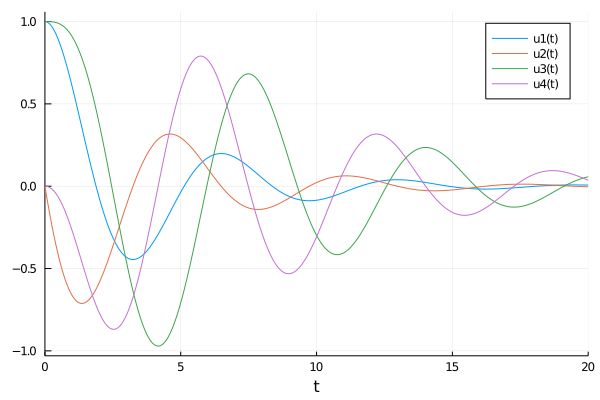

In [46]:
# Initial condition
u_init = [-10, 10];       # 4 initial values are theoretically required. However, only 2 compile.
                          # It also seems the values of u0 have no effect, and this is substituted by xs.
# Position, velocity
xs_init = [1, 0, 1, 0];   # Inputs are equal to the number of states, in spite of wire connections.

# Interval of solution
t_span = (0, 20);      

# Solve system
sol = solve( ODEProblem(spring_damper_machine, xs_init, u_init, t_span), alg_hints=[:stiff] );

plot(sol)